# Correlated Truncation Errors in Effective Field Theory: The code behind the manuscript

This notebook provides the code to reproduce all of the plots from Melendez et al. (2019).
Notebook written by Jordan Melendez.
Commentary by Daniel Phillips and Dick Furnstahl, June 2019.


*Note*: Since publication we have switched the `pivoted_cholesky` function from an underlying GSL to a LAPACK routine.
Their output is generally identical but the exact results can differ very slightly depending on fine details of the input matrix.
Thus some of the PC plots may not be identical to their published versions, but the overall conclusions remain unchanged. (Currently only Fig. 7(c) has changed.)

In [1]:
import gsum as gm
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import os
import h5py
from sklearn.gaussian_process.kernels import RBF, WhiteKernel
import math
import urllib
import tables
import colorsys
import ipywidgets as widgets
from IPython.display import display
import warnings

%matplotlib inline

from toymodel_imports import scale_lightness, GPHyperparameters, order_info, \
regular_train_test_split, find_nearest, mask_mapper, offset_xlabel, PosteriorBounds, \
joint_plot, GSUMobj

In C:\Users\pjmil\anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\pjmil\anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\pjmil\anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In C:\Users\pjmil\anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\pjmil\anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mpl

In [2]:
# plotting parameters
# See: https://ianstormtaylor.com/design-tip-never-use-black/
# softblack = '#262626'
softblack = 'k'  # Looks better when printed on tex file
gray = '0.7'
# list(mpl.rcParams['axes.prop_cycle'])
mpl.rcParams['figure.dpi'] = 180
mpl.rcParams['font.size'] = 9
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'

mpl.rcParams['axes.labelsize'] = 9
mpl.rcParams['axes.edgecolor'] = softblack
mpl.rcParams['axes.xmargin'] = 0
mpl.rcParams['axes.labelcolor'] = softblack
mpl.rcParams['axes.linewidth']

mpl.rcParams['ytick.direction'] = 'in'
mpl.rcParams['xtick.direction'] = 'in'
mpl.rcParams['xtick.labelsize'] = 9
mpl.rcParams['ytick.labelsize'] = 9
mpl.rcParams['xtick.color'] = softblack
mpl.rcParams['ytick.color'] = softblack
mpl.rcParams['xtick.minor.size'] = 2.4
mpl.rcParams['ytick.minor.size'] = 2.4

mpl.rcParams['legend.title_fontsize'] = 9
mpl.rcParams['legend.fontsize'] = 9
mpl.rcParams['legend.edgecolor'] = 'inherit'  # inherits from axes.edgecolor, to match
mpl.rcParams['legend.facecolor'] = (1, 1, 1, 0.6)  # Set facecolor with its own alpha, so edgecolor is unaffected
mpl.rcParams['legend.fancybox'] = True
mpl.rcParams['legend.borderaxespad'] = 0.8
mpl.rcParams['legend.framealpha'] = None  # Do not set overall alpha (affects edgecolor). Handled by facecolor above
mpl.rcParams['patch.linewidth'] = 0.8  # This is for legend edgewidth, since it does not have its own option

text_bbox = dict(boxstyle='round', fc=(1, 1, 1, 0.6), ec=softblack, lw=0.8)
mpl.rc('savefig', transparent=False, bbox='tight', pad_inches=0.05, dpi=300, format='pdf')

edgewidth = 0.6

In [3]:
def plot_MD_widget(widgethyper, orderswidget, x, slider_ls_value, slider_sd_value, \
                   slider_power_value, change_order_array, change_ratio_array, seed_array, \
                   plot_type, color_seed = None):
    """
    Designed simply to take in hyperparamters and order information (including widgets), generate 
    a GSUMobj, change the desired order(s), and plot the Mahalanobis distance.
    """
    # makes the GSUM object that will involve the widgets
    WidgetGP = GSUMobj(widgethyper, orderswidget, x, color_seed = color_seed, \
                       fullyrandomcolors = True, x_power = slider_power_value)
    WidgetGP.change_order(change_order_array, change_ratio_array, np.array([slider_ls_value]), \
                      np.array([slider_sd_value]), seed_array)
    try:
        WidgetGP.PlotMD(plot_type = plot_type)
    except:
        print("The Mahalanobis distance could not be calculated at one or more orders.")

def plot_PC_widget(widgethyper, orderswidget, x, slider_ls_value, slider_sd_value, \
                    slider_power_value, change_order_array, change_ratio_array, seed_array, \
                    color_seed = None):
    """
    Designed simply to take in hyperparamters and order information (including widgets), generate 
    a GSUMobj, change the desired order(s), and plot the pivoted Cholesky decomposition.
    """
    # makes the GSUM object that will involve the widgets
    WidgetGP = GSUMobj(widgethyper, orderswidget, x, color_seed = color_seed, \
                       fullyrandomcolors = True, x_power = slider_power_value)
    WidgetGP.change_order(change_order_array, change_ratio_array, np.array([slider_ls_value]), \
                      np.array([slider_sd_value]), seed_array)
    try:
        WidgetGP.PlotPC()
    except:
        print("The pivoted Cholesky decomposition could not be calculated at one or more orders.")

def plot_weather_widget(widgethyper, orderswidget, x, slider_ls_value, slider_sd_value, \
                    slider_power_value, change_order_array, change_ratio_array, seed_array, \
                    color_seed = None):
    """
    Designed simply to take in hyperparamters and order information (including widgets), generate 
    a GSUMobj, change the desired order(s), and plot the credible intervals
    """
    # makes the GSUM object that will involve the widgets
    WidgetGP = GSUMobj(widgethyper, orderswidget, x, color_seed = color_seed, \
                       fullyrandomcolors = True, x_power = slider_power_value)
    WidgetGP.change_order(change_order_array, change_ratio_array, np.array([slider_ls_value]), \
                      np.array([slider_sd_value]), seed_array)
    try:
        WidgetGP.PlotCredibleIntervals()
    except:
        print("The credible intervals could not be calculated at one or more orders.")

def plot_posterior_widget(widgethyper, orderswidget, x, slider_ls_value, slider_sd_value, \
                       slider_power_value, change_order_array, change_ratio_array, seed_array, \
                       widgetposteriorbounds, color_seed = None):
    """
    Designed simply to take in hyperparamters and order information (including widgets), generate 
    a GSUMobj, change the desired order(s), and plot the posterior probability distribution 
    function.
    """
    # makes the GSUM object that will involve the widgets
    WidgetGP = GSUMobj(widgethyper, orderswidget, x, color_seed = color_seed, \
                       fullyrandomcolors = True, x_power = slider_power_value)
    WidgetGP.change_order(change_order_array, change_ratio_array, np.array([slider_ls_value]), \
                      np.array([slider_sd_value]), seed_array)
    try:
        WidgetGP.PlotPosteriorPDF(widgetposteriorbounds)
    except:
        print("The posterior probability distribution could not be calculated.")

def plot_diagnostics_widget(widgethyper, orderswidget, x, slider_ls_value, slider_sd_value, \
                   slider_power_value, change_order_array, change_ratio_array, seed_array, \
                   widgetposteriorbounds, plot_type = 'box', color_seed = None):
    """
    Designed simply to take in a GP and order information (including the correlation length from a slider 
    widget), change the desired order(s), and plot the Mahalanobis distance, the pivoted 
    Cholesky decomposition, the credible intervals, and the posterior PDF. Also suppresses 
    warnings.
    """
    # makes the GSUM object that will involve the widgets
    WidgetGP = GSUMobj(widgethyper, orderswidget, x, color_seed = color_seed, \
                       fullyrandomcolors = True, x_power = slider_power_value)
    WidgetGP.change_order(change_order_array, change_ratio_array, np.array([slider_ls_value]), \
                      np.array([slider_sd_value]), seed_array)
    
    # we don't need to bother with warnings when we run this snippet of code
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        
        try:
            WidgetGP.PlotMD(plot_type = plot_type)
        except:
            print("The Mahalanobis distance could not be calculated at one or more orders.")
        try:
            WidgetGP.PlotPC()
        except:
            print("The pivoted Cholesky decomposition could not be calculated at one or more orders.")
        try:
            WidgetGP.PlotCredibleIntervals()
        except:
            print("The credible intervals could not be calculated at one or more orders.")
        try:
            WidgetGP.PlotPosteriorPDF(widgetposteriorbounds)
        except:
            print("The posterior probability distribution could not be calculated.")

# Part I: Gaining Intuition with Widgets

In [4]:
x = np.linspace(0, 1, 100) # grid for x-values

n_orders = 10    # Here we examine the case where we have info on some number of non-trivial orders
final_order = 50  # We are going to treat some high order result as the final, converged answer

# creates the order_info object, which contains information on the total number of orders to be 
# calculated and the number of orders to be plotted
OrdersWidget = order_info(n_orders, final_order)
orders_widget = OrdersWidget.orders_array
orders_all_widget = OrdersWidget.orders_all_array

# The true values of the hyperparameters for generating the EFT coefficients
ls = 0.2
sd = 1
center = 0
ref = 10
ratio = 0.5
nugget = 1e-10
seed = None
WidgetHyper = GPHyperparameters(ls = ls, sd = sd, center = center, ref = ref, ratio = ratio, \
                                nugget = nugget, seed = seed)

# posterior grid for the widget
WidgetPosteriorBounds = PosteriorBounds(1e-3, 0.5, 100, 0.3, 0.7, 80)

In [5]:
# we will alter the hyperparameters of the third order alone
change_order_array = [3]
change_ratio_array = [ratio]

# the RNG seed for the altered order can be set manually, chosen once for many runs, or 
# chosen randomly for each run
# seed_array = [16]
# seed_array = np.random.randint(0, 2000000, 1)
seed_array = [None]

# sets a seed for the random color-chooser for stability across parameters and diagnostic widgets
# good ones: 62, 75, 81, 82, 90
color_seed_widget = 81

In [6]:
# initializes a slider for the correlation length in terms of the default value
slider_ls = widgets.FloatSlider(
    min = ls * 3/4,
    max = ls * 5/3,
    step = 0.01,
    description = 'Length scale:',
    value = ls, 
    continuous_update = False
)

# initializes a slider for the variance in terms of the default value
slider_sd = widgets.FloatSlider(
    min = sd * 0.3,
    max = sd / 0.3,
    step = 0.01,
    description = 'Variance:',
    value = sd, 
    continuous_update = False
)

# initializes a slider for the polynomial power of x in terms of the default value
slider_power = widgets.RadioButtons(
    options = [0.250, 0.333, 0.500, 1.000, 2.000, 3.000, 4.000],
    value = 1., 
    description = 'x-power:',
    disabled = False, 
    continuous_update = False
)

##### This is a table of the visual signatures in our statistical diagnostics of pathologies at certain orders (namely, different correlation length, different variance, and polynomial scaling). See if you can replicate these results.

| CETERIS PARIBUS | Mahalanobis distance | Pivoted Cholesky decomposition | Credible interval | $Q$-$\ell$ posterior|
| --- | --- | --- | --- | --- |
| Lower one order's correlation length | That order rises a lot | That order is out of bounds for higher index; other orders too, but less so | X | X |
| Raise one order's correlation length | That order falls a lot | Funnel-shaped overall distribution, but with that order hewing closely to the mean | X | X |
| Lower one order's variance | That order falls a little | That order hews closely to the mean | X | X |
| Raise one order's variance | That order rises a little | That order goes out of bounds | X | X |
| $x \rightarrow x^{n}, n > 1$ | Scattered | Harsh funnel | Some lines go out of bounds | Higher $n$ $\rightarrow$ higher predicted correlation length |
| $x \rightarrow x^{\frac{1}{n}}, n > 1$ | Scattered | Harsh funnel | Some lines go out of bounds | X |

#### Plot all diagnostics (manual update)

This cell plots all four statistical diagnostics of interest--the squared Mahalanobis distance, the pivoted Cholesky decomposition, the credible intervals, and the $Q-\ell$ posterior probability distribution function; further explanation for each can be found below. The user must click to generate new figures.

In [7]:
# plotting all the diagnostics without interative_output
interactive_plot_all = widgets.interactive(plot_diagnostics_widget, {'manual': True}, \
                                      slider_ls_value = slider_ls, \
                                      slider_sd_value = slider_sd, \
                                      slider_power_value = slider_power, \
                                      widgethyper = widgets.fixed(WidgetHyper), \
                                      orderswidget = widgets.fixed(OrdersWidget), \
                                      x = widgets.fixed(x), \
                                      change_order_array = widgets.fixed(change_order_array), \
                                      change_ratio_array = widgets.fixed(change_ratio_array), \
                                      seed_array = widgets.fixed(seed_array), \
                                      widgetposteriorbounds = widgets.fixed(WidgetPosteriorBounds), \
                                      color_seed = widgets.fixed(color_seed_widget), \
                                      plot_type = widgets.fixed('box'))
output = interactive_plot_all.children[-1]
interactive_plot_all

interactive(children=(FloatSlider(value=0.2, continuous_update=False, description='Length scale:', max=0.33333…

#### Plot Mahalanobis distance (manual update)

The squared Mahalanobis distance ("MD") is like a $\chi^{2}$ in the presence of correlations, where the correlations are assessed using the covariance matrix of the fitted GP. As with $\chi^{2}$, a high value MD signals a poor fit and a low value a good fit.

You can plot both a box-and-whisker and a histogram version by changing the value of `plot_type` to `'box'` or `'hist'`, respectively.

In [8]:
# using the slider interactively, plots the Mahalanobis distance
interactive_plot_md = widgets.interactive(plot_MD_widget, {'manual': True}, \
                                          slider_ls_value = slider_ls, \
                                          slider_sd_value = slider_sd, \
                                          slider_power_value = slider_power, \
                                          widgethyper = widgets.fixed(WidgetHyper), \
                                          orderswidget = widgets.fixed(OrdersWidget), \
                                          x = widgets.fixed(x), \
                                          change_order_array = widgets.fixed(change_order_array), \
                                          change_ratio_array = widgets.fixed(change_ratio_array), \
                                          seed_array = widgets.fixed(seed_array), \
                                          plot_type = widgets.fixed('box'), \
                                          color_seed = widgets.fixed(color_seed_widget))
output = interactive_plot_md.children[-1]
interactive_plot_md

interactive(children=(FloatSlider(value=0.2, continuous_update=False, description='Length scale:', max=0.33333…

#### Plot pivoted Cholesky decomposition (manual update)

Now we decompose the Mahalanobis distance into its component pieces by performing a pivoted Cholesky ("PC") decomposition on the covariance matrix. The resulting PC errors are then plotted against index, with large values indicating poor fit as usual. The index can be related to the testing point in question (see Bastos & O'Hagan's seminal article). Telltale signs of pathology in the convergence pattern include an order's errors hewing too close to the mean or falling outside the typical standard deviation, or a funnel-shaped overall distribution.

In [9]:
# using the slider interactively, plots the pivoted Cholesky decomposition
interactive_plot_pc = widgets.interactive(plot_PC_widget, {'manual': True}, \
                                          slider_ls_value = slider_ls, \
                                          slider_sd_value = slider_sd, \
                                          slider_power_value = slider_power, \
                                          widgethyper = widgets.fixed(WidgetHyper), \
                                          orderswidget = widgets.fixed(OrdersWidget), \
                                          x = widgets.fixed(x), \
                                          change_order_array = widgets.fixed(change_order_array), \
                                          change_ratio_array = widgets.fixed(change_ratio_array), \
                                          seed_array = widgets.fixed(seed_array), \
                                          color_seed = widgets.fixed(color_seed_widget))
output = interactive_plot_pc.children[-1]
interactive_plot_pc

interactive(children=(FloatSlider(value=0.2, continuous_update=False, description='Length scale:', max=0.33333…

#### Plot the credibility intervals, or "weather plot" (manual update)

Weather forecasting services assign percentage probabilities to the likelihood of precipitation, sunlight, wind, and other meteorological phenomena. If the forecaster is maximally statistically rigorous, that predicted likelihood should converge with the frequentist approach to predicting weather, so that, for example, it should rain on 40% of the days when a 40% chance of rain was forecast. Likewise, we should find that our prediction for the value of some observable (a unitless, meaningless toy observable, in this case) should fall within the 10% confidence interval (measured about the mean) 10% of the time, within 20% 20% of the time, within 30% 30% of the time, etc.

Due to the sparseness of our data, however, by comparison to the far more numerous data of a weather forecaster, that ideal $45^{\circ}$ line itself has error bars, and we plot the 68% confidence interval in the dark gray about that line and the 95% confidence interval in light gray. If our assignment of probabilities is rigorous, our predictions should fall within the dark gray about 68% (roughly two thirds) of the time and within the light gray 95% of the time (roughly nineteen out of twenty times). When a particular order of calculation falls outside these bounds too often, that is a sign that the convergence pattern may be pathological.

In [10]:
interactive_plot_weather = widgets.interactive(plot_weather_widget, {'manual': True}, \
                                          slider_ls_value = slider_ls, \
                                          slider_sd_value = slider_sd, \
                                          slider_power_value = slider_power, \
                                          widgethyper = widgets.fixed(WidgetHyper), \
                                          orderswidget = widgets.fixed(OrdersWidget), \
                                          x = widgets.fixed(x), \
                                          change_order_array = widgets.fixed(change_order_array), \
                                          change_ratio_array = widgets.fixed(change_ratio_array), \
                                          seed_array = widgets.fixed(seed_array), \
                                          color_seed = widgets.fixed(color_seed_widget))
output = interactive_plot_weather.children[-1]
interactive_plot_weather

interactive(children=(FloatSlider(value=0.2, continuous_update=False, description='Length scale:', max=0.33333…

#### Plot the $Q-\ell$ posterior probability distribution function (manual update)

Taking a Bayesian approach, we can define a likelihood probability distribution function ("PDF") that takes the form of a $\chi^{2}$ and a uniform prior PDF; evaluate their product at each point on a two-dimensional grid in the space defined by $Q$, the dimensionless expansion parameter, and $\ell$, the correlation length of the fitted GP; plot the result, with darker areas having higher probability; plot the "true" values that we actually used for our calculations; and compare. Convergence may be pathological when the true value lies too far from an area of high probability.

In [11]:
interactive_plot_posterior = widgets.interactive(plot_posterior_widget, {'manual': True}, \
                                          slider_ls_value = slider_ls, \
                                          slider_sd_value = slider_sd, \
                                          slider_power_value = slider_power, \
                                          widgethyper = widgets.fixed(WidgetHyper), \
                                          orderswidget = widgets.fixed(OrdersWidget), \
                                          x = widgets.fixed(x), \
                                          change_order_array = widgets.fixed(change_order_array), \
                                          change_ratio_array = widgets.fixed(change_ratio_array), \
                                          seed_array = widgets.fixed(seed_array), \
                                          widgetposteriorbounds = widgets.fixed(WidgetPosteriorBounds), \
                                          color_seed = widgets.fixed(color_seed_widget))
output = interactive_plot_posterior.children[-1]
interactive_plot_posterior

interactive(children=(FloatSlider(value=0.2, continuous_update=False, description='Length scale:', max=0.33333…

#### Plot all diagnostics (automatic update)

This cell plots all four statistical diagnostics of interest--the squared Mahalanobis distance, the pivoted Cholesky decomposition, the credible intervals, and the $Q-\ell$ posterior probability distribution function. Figures generate automatically whenever the values of the widgets are changed.

In [12]:
# Set up the interactive_output widget 
plot_out = widgets.interactive_output(plot_diagnostics_widget, \
                        dict(
                        widgethyper = widgets.fixed(WidgetHyper), \
                        orderswidget = widgets.fixed(OrdersWidget), \
                        x = widgets.fixed(x), \
                        slider_ls_value = slider_ls, \
                        slider_sd_value = slider_sd, \
                        slider_power_value = slider_power, \
                        change_order_array = widgets.fixed(change_order_array), \
                        change_ratio_array = widgets.fixed(change_ratio_array), \
                        seed_array = widgets.fixed(seed_array), \
                        widgetposteriorbounds = widgets.fixed(WidgetPosteriorBounds), \
                        plot_type = widgets.fixed('box'), \
                        color_seed = widgets.fixed(color_seed_widget))
                        )
plot_out.observe(True, names = 'manual')

# plot_out = widgets.interactive_output(plot_diagnostics_widget, \
#                         {'manual': True, \
#                         'widgethyper': widgets.fixed(WidgetHyper), \
#                         'orderswidget': widgets.fixed(OrdersWidget), \
#                         'x': widgets.fixed(x), \
#                         'slider_ls_value': slider_ls, \
#                         'slider_sd_value': slider_sd, \
#                         'slider_power_value': slider_power, \
#                         'change_order_array': widgets.fixed(change_order_array), \
#                         'change_ratio_array': widgets.fixed(change_ratio_array), \
#                         'seed_array': widgets.fixed(seed_array), \
#                         'widgetposteriorbounds': widgets.fixed(WidgetPosteriorBounds), \
#                         'plot_type': widgets.fixed('box'), \
#                         'color_seed': widgets.fixed(color_seed_widget)}
#                         )

# Now do some manual layout, where we can put the plot anywhere using plot_out
vbox1 = widgets.VBox([slider_ls, slider_sd])
hbox1 = widgets.HBox([vbox1, slider_power])

# We'll set up Tabs to organize the controls.  The Tab contents are declared
#  as tab0, tab1, ... (probably should make this a list?) and the overall Tab
#  is called tab (so its children are tab0, tab1, ...).
tab_height = '70px'  # Fixed minimum height for all tabs. Specify another way?
tab0 = widgets.VBox([hbox1], layout=widgets.Layout(min_height=tab_height))
tab = widgets.Tab(children=[tab0])
tab.set_title(0, 'GP Parameters')

# Release the Kraken!
vbox1 = widgets.VBox([tab, plot_out])
display(vbox1)

## Part II: Applying the Model

### Figure 1: Predictions to Coefficients

First we set up our toy data. Each coefficient in the EFT is a sample from a GP, with a squared exponential kernel, and the same correlation length (0.2) and standard deviation (1) at each order. The expansion parameter is 0.5 (quite large). The code below first generates the coefficients, and then creates predictions that are a sum of these order-by-order pieces by following

\begin{align*}
y_k = y_{\mathrm{ref}} \sum_{n=0}^k c_n Q^n
\end{align*}

Note that within the toy model, one is guaranteed to recover the individual realizations of the GP $c_n$ by inverting this relation *if one has chosen the correct expansion parameter*.

The following section can reproduce the figures in the paper "Quantifying Correlated Truncation Errors in Effective Field Theory," which can be found on the arXiv at https://arxiv.org/abs/1904.10581, with the following parameter values:

* `x = np.linspace(0, 1, 100)`

* `n_orders = 4`
* `final_order = 20`

* `ls = 0.2`
* `sd = 1`
* `center = 0`
* `ref = 10`
* `ratio = 0.5`
* `nugget = 1e-10`
* `seed = 3`

* `fullyrandomcolors = False`
* `color_seed = None`
* `constrained = False`
* `x_power = 1`
* And don't change any orders.

In [13]:
x = np.linspace(0, 1, 100) # grid for x-values
x_power = 2 # polynomial scaling factor for x-axis

n_orders = 10    # Here we examine the case where we have info on some numer of non-trivial orders
final_order = 50  # We are going to treat some high order result as the final, converged answer

# creates the orders_info object
OrdersBig = order_info(n_orders, final_order)
orders_big = OrdersBig.orders_array
orders_all_big = OrdersBig.orders_all_array

# The true values of the hyperparameters for generating the EFT coefficients
ls = 0.2
sd = 1
center = 0
ref = 10
ratio = 0.5
nugget = 1e-10
seed = None
JordanHyper = GPHyperparameters(ls = ls, sd = sd, center = center, ref = ref, ratio = ratio, \
                                nugget = nugget, seed = seed)

# makes the GSUM object
MyGP = GSUMobj(JordanHyper, OrdersBig, x, x_power = x_power)

In [14]:
# let's throw off some orders and see what happens
n_orders_spread = 5
change_order_array = np.random.randint(0, final_order + 1, n_orders_spread)
# change_order_array = np.array([0, 2, 7, 10, 30])
print("Adjusted orders: " + str(change_order_array))
change_ratio_array = np.random.normal(ratio, ratio * 0.2, n_orders_spread)
# change_ratio_array = np.random.normal(ratio, ratio * 0.2, 1) * np.ones(n_orders_spread)
print("Adjusted ratios: " + str(change_ratio_array))
change_ls_array = np.random.normal(ls, ls * 0.2, n_orders_spread)
# change_ls_array = np.random.normal(ls, ls * 0.2, 1) * np.ones(n_orders_spread)
# change_ls_array = 0.15 * np.ones(n_orders_spread)
print("Adjusted correlation lengths: " + str(change_ls_array))
change_sd_array = np.random.normal(sd, sd * 0.2, n_orders_spread)
print("Adjusted variances: " + str(change_sd_array))
seed_array = np.random.randint(0, 2000000, n_orders_spread)
print("Adjusted seeds: " + str(seed_array))
MyGP.change_order(change_order_array, change_ratio_array, change_ls_array, change_sd_array, \
                   seed_array)

Adjusted orders: [18 23 17 32 28]
Adjusted ratios: [0.3976083  0.55694049 0.60428248 0.43594273 0.54376489]
Adjusted correlation lengths: [0.18665662 0.1083576  0.20944282 0.1877757  0.14924598]
Adjusted variances: [1.0207087  0.70122115 0.88381051 0.98099935 0.72492258]
Adjusted seeds: [1440629  886656  136245 1944542  737047]


## Reproducing Fig. 1(a, b, c)

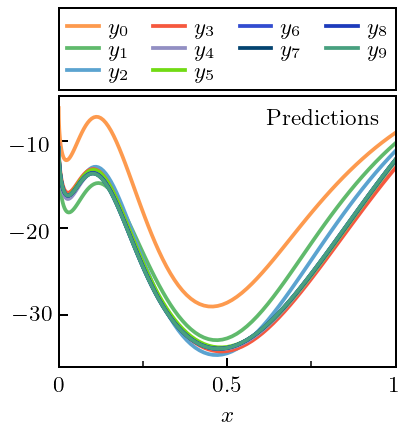

In [15]:
MyGP.PlotCurvesFull()

C:\Users\pjmil\anaconda3\lib\_collections_abc.py:832: MatplotlibDeprecationWarning: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  self[key] = other[key]


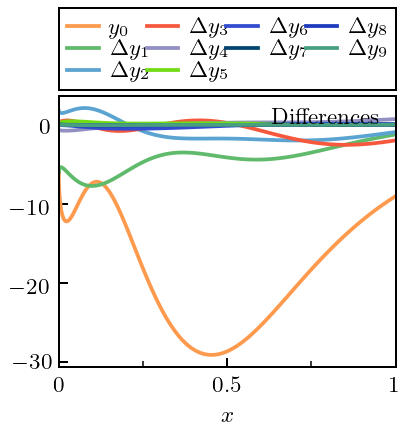

In [16]:
MyGP.PlotCurvesDiffs()

Now show the coefficients $c_n$ (each drawn from one underlying Gaussian Process).
Of course, in a real application, these coefficients would be extracted from the EFT predictions by diving $\Delta y_n$ by $Q^n$.

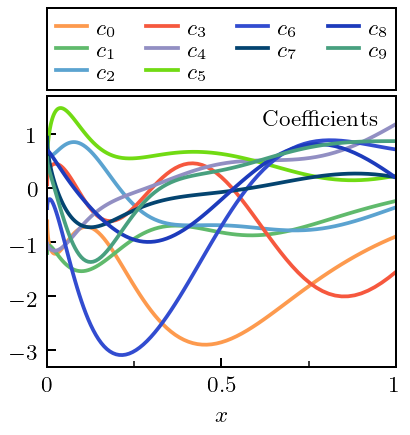

In [17]:
MyGP.PlotCurvesCoeffs()

### Figure 3: Curvewise vs Pointwise Analysis

This next piece of code returns to the curves from Fig. 1(c), and then chooses specific points $x_i$ and computes the standard deviation of the $c_n(x_i)$. It compares that to the standard deviation of the underlying GP.
This "pointwise" approach was employed in Melendez et al. (2017) using a Bayesian formalism. The new GP approach has the advantage of combining data from across the domain (accounting for correlations!) to estimate the variance $\bar c$.

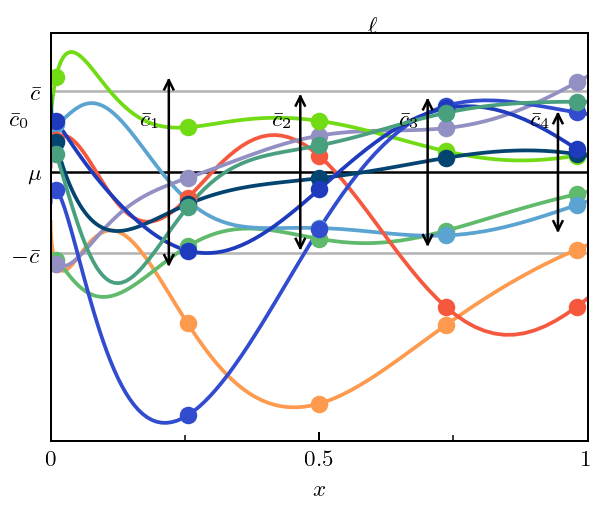

In [18]:
# creates a "mask" of points for comparing expected and true GP curve variance
MyGP.PlotPointwiseVariance(MyGP.x_train_mask)

### Figure 4: Interpolation and Regression with Gaussian Processes

Now we do an example of interpolation, where the training points are exact ($\sigma_n=0$) and regression, where the training points have some errors (we choose $\sigma_n=0.15$).
Training points are shown, with true curves indicated as solid lines, and mean of GP the dashed line. The bands are 95% (2$\sigma$) credible intervals.
For this exercise we choose the underlying curves to be $c_1$ (interpolation) and $c_3$ (regression). 

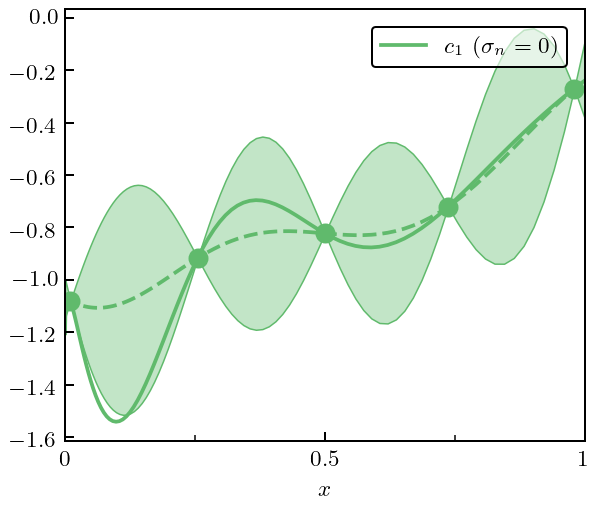

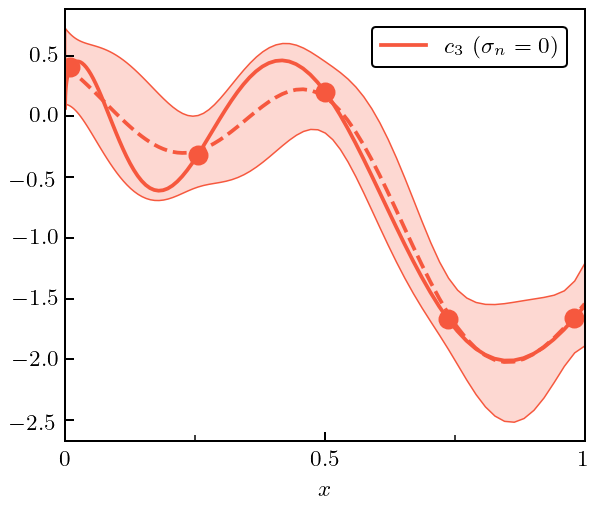

In [19]:
interp_idx = 1  # pick out c_1
MyGP.PlotSingleCurveFit(interp_idx, mask = MyGP.x_train_mask, disp = 0, df = np.inf, scale = sd, nugget = 0)

regres_sd = 0.15 # pointwise uncertainty
regres_idx = 3  # pick out c_3
MyGP.PlotSingleCurveFit(regres_idx, mask = MyGP.x_train_mask, disp = 0, df = np.inf, scale = sd, \
                        nugget = regres_sd**(2))

### Figure 5: GP Priors

Now we plot the priors on our GP. The prior on $\mu$ is a Gaussian, for a given value of $\bar{c}$. For $\bar{c}$ we take a prior that is an inverse $\chi^2$ distribution. The parameters of the $\chi^2$ are:
1. $\nu_0$, the prior number of degrees of freedom;
2. $\tau_0^2$, the prior scale. If $\nu$ becomes large this becomes the MAP value for $\bar{c}$. 

Note that in the opposite limit, where $\nu_0=0$ the prior becomes the scale invariant "Jeffreys prior".

The joint prior pdf is then
$$\mu,\bar{c}^2 \sim N \chi^{-2}(\eta_0,V_0,\nu_0,\tau_0^2)$$

This is mathematically equivalent to a normal-inverse-gamma prior, a fact which we exploit below.

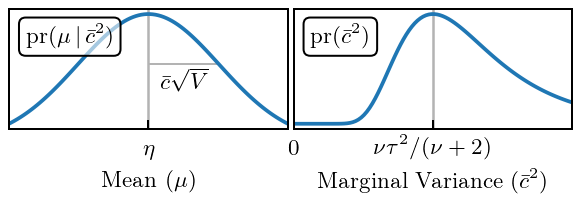

In [20]:
softblack = 'k'
gray = '0.7'
text_bbox = dict(boxstyle='round', fc=(1, 1, 1, 0.6), ec=softblack, lw=0.8)

mean = 0
# The uncertainty (std-dev) of mu is Sqrt(V) times cbar,
# the plot is generated for V=1
disp = 1
df = 15
tau2 = (df + 2) / df  # Will put the mode at $\bar c = 1$
gaussian_sd = np.sqrt(tau2*disp)

# Convert to inverse gamma
a = df / 2.
b = df * tau2 / 2.

gaus = stats.norm(mean, gaussian_sd)
igam = stats.invgamma(a, scale=b)
mu_vals = np.linspace(-2.1, 2.1, 100)
cbar_vals = np.linspace(0, 2, 100)

fig, ax = plt.subplots(1, 2, figsize=(3.4, 1.3))

# Plot curves
ax[0].plot(mu_vals, gaus.pdf(mu_vals))
ax[1].plot(cbar_vals, igam.pdf(cbar_vals))

# Add text boxes
ax[0].text(0.06, 0.87, r'pr($\mu \,|\, \bar c^2$)', ha='left', va='top',
           transform=ax[0].transAxes,
           bbox=text_bbox)
ax[1].text(0.06, 0.87, r'pr($\bar c^2$)', ha='left', va='top',
           transform=ax[1].transAxes,
           bbox=text_bbox
          )

# Format plots
line_color = gray
ax[0].set_xlabel(r'Mean ($\mu$)', labelpad=4.5)
# ax[0].set_xlabel(r'Mean ($\mu$)')
ax[1].set_xlabel(r'Marginal Variance ($\bar c^2$)')
ax[0].set_yticks([])
ax[1].set_yticks([])
# plt.xlabel()

ax[0].axvline([mean], 0, 1, c=line_color, zorder=0, lw=1)
# ax[0].set_xticks([-gaussian_sd, mean, gaussian_sd])
# ax[0].set_xticklabels([r'$-\bar c\sqrt{V}$', r'$\eta$', r'$\bar c\sqrt{V}$'], va='bottom')
ax[0].set_xticks([mean])
ax[0].set_xticklabels([r'$\eta$'], va='bottom')
ax[0].tick_params(pad=12)
ax[0].arrow(0, gaus.pdf(gaussian_sd), gaussian_sd, 0, color=line_color, head_width=0., width=0.0001)
# ax[0].text(gaussian_sd+0.25, gaus.pdf(gaussian_sd), r'$\bar c\sqrt{V}$',
#            verticalalignment='center', horizontalalignment='left')
ax[0].text(gaussian_sd/2, gaus.pdf(gaussian_sd)-.02, r'$\bar c\sqrt{V}$',
           verticalalignment='top', horizontalalignment='center')
ax[1].axvline([df * tau2 / (df+2)], 0, 1, c=line_color, zorder=0, lw=1)
ax[1].set_xticks([0, df * tau2 / (df+2)])
ax[1].set_xticklabels([0, r'$\nu\tau^2/(\nu+2)$'], va='bottom')
ax[1].tick_params(pad=12)

fig.tight_layout(w_pad=0)
# fig.savefig('figures/priors')

### Figure 6: Applications

We now consider three different situations where we can use our formalism to compute truncation errors.
1. Straightforward computation in the situation that computing $y_k(x)$ is "cheap", and we can evaluate it at as many points as we wish.
2. The situation where computing $y_k(x)$ is expensive, and we wish to obtain the uncertainty at some $x$, where $y_k(x)$ was not explicitly computed. In this situation we will use our GPs for interpolation too, and then combine the interpolation and truncation error to assess the overall error of our prediction.
3. Truncation errors in the presence of constraints, i.e., a situation where a symmetry guarantees that $\delta y_k(x_0)=0$ at some particular $x_0$.

#### Figure 6(a): Inexpensive Systems

In the figure we show the "EFT prediction" $y_n(x)$ at each order $n$, together with the associated 95% credible interval. The code to do this is actually just two lines, now that we have set up the input data, the mask, and the GP kernel. 

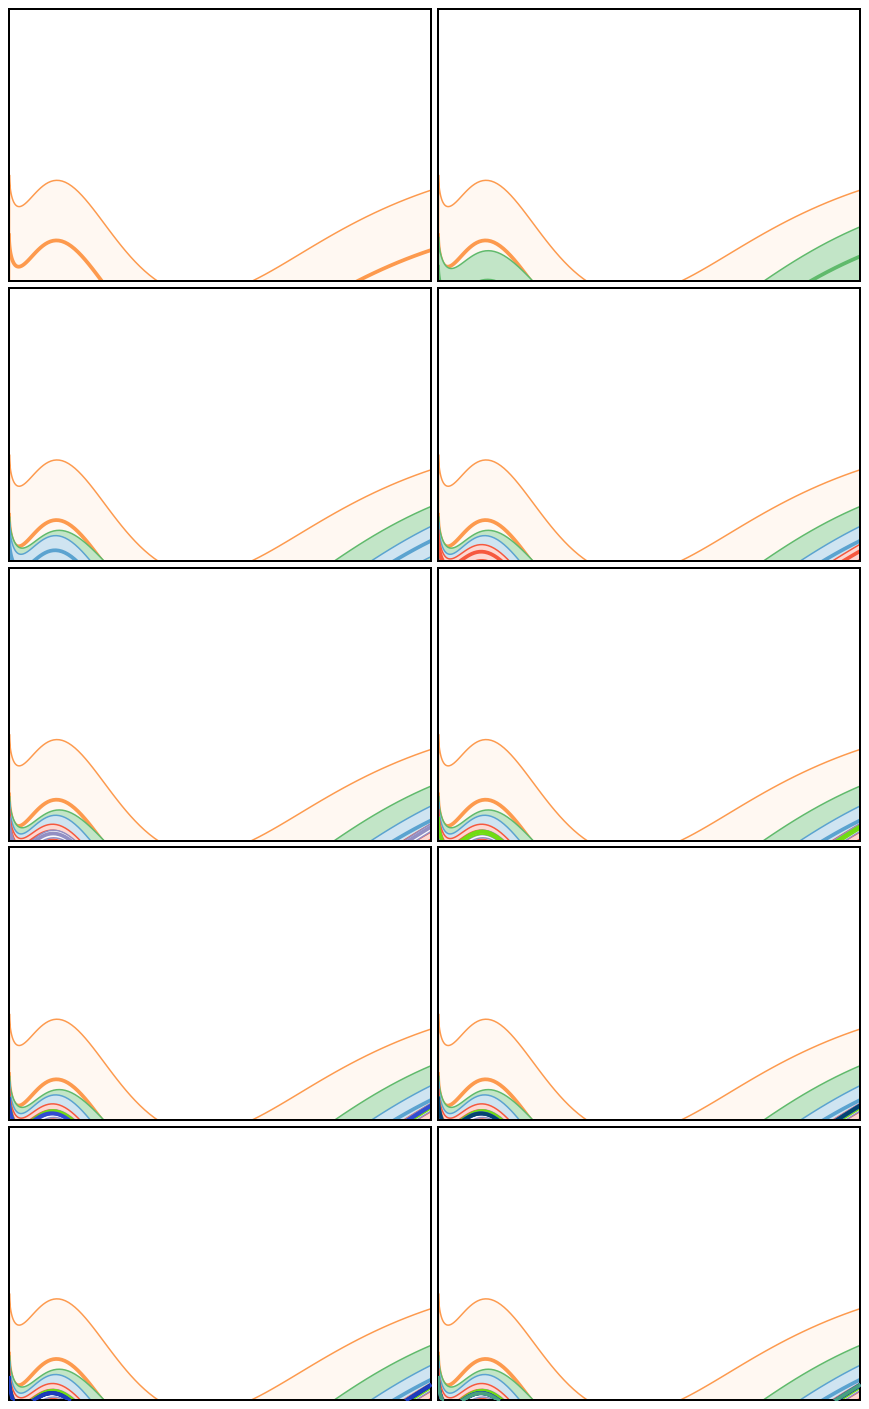

In [21]:
MyGP.PlotPointwiseFit(MyGP.x_train_mask, expensive = False)

#### Figure 6(b): Expensive Systems

The figures in this case are similar, but now the GP is trained only at the points indicated by the dots.
The total error bands now include both truncation and interpolation error.
Note how the total error on the EFT prediction expands or contracts as one moves away from or towards the points where we have "exact" EFT calculations.

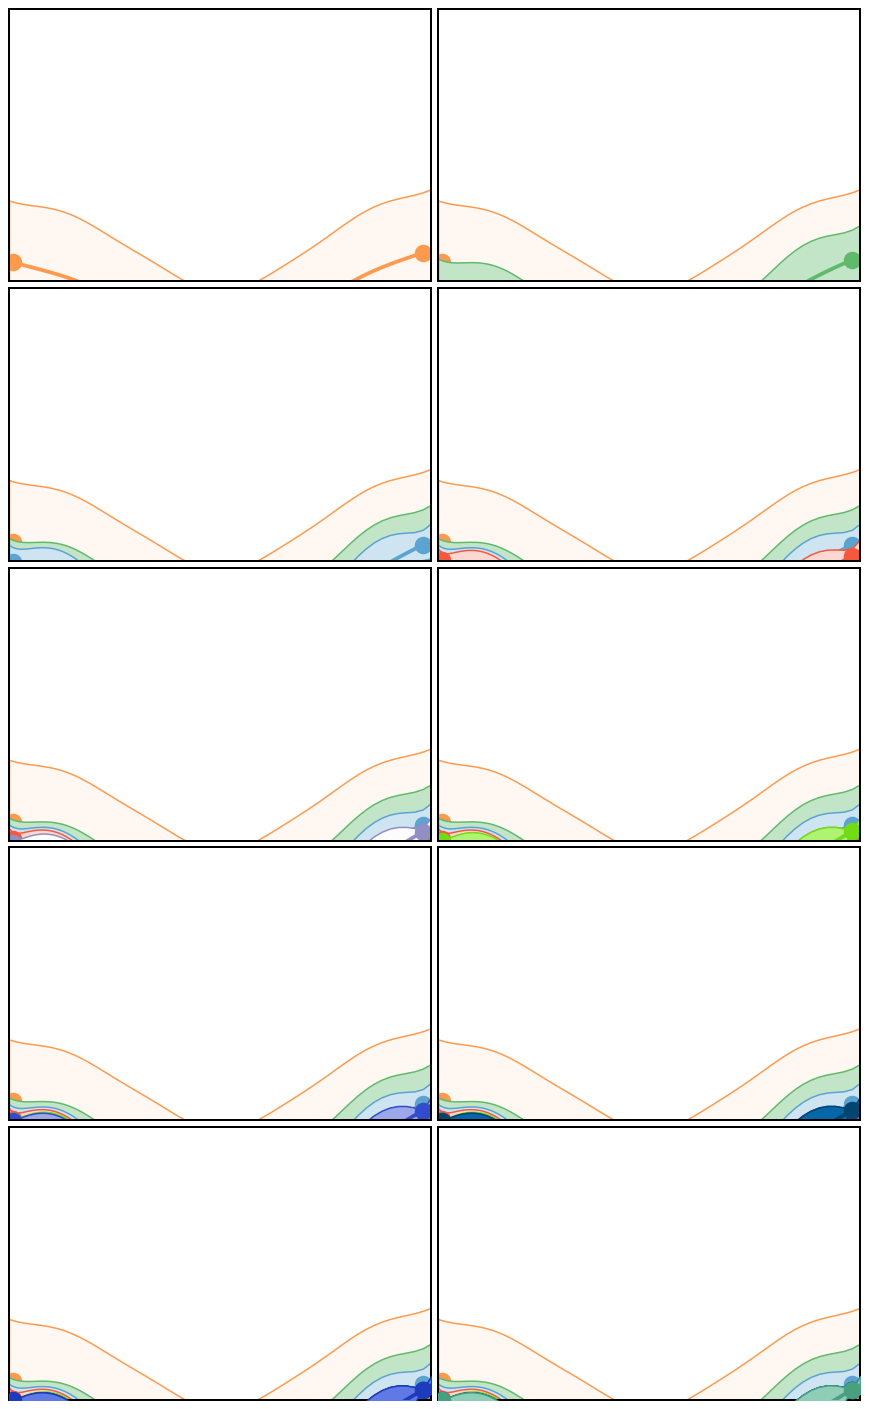

In [22]:
MyGP.PlotPointwiseFit(MyGP.x_train_mask, expensive = True)

#### Figure 6(c): Constraints

We now consider the case that the observable in question is constrained to be zero at both x=0 and x=1. This means that the EFT should maintain that constraint at all orders, and that the truncation-error model should incorporate that constraint. The truncation classes in `gsum` have two parameters in their `.fit` methods that permit the inclusion of constraints: `dX` and `dy`. Using that feature, things proceed in parallel to Fig. 6(a).

In [23]:
# This generates data that are constrained as described above
ConstrainedHyper = GPHyperparameters(ls = 0.25, sd = sd, center = center, ref = ref, ratio = ratio, \
                                nugget = 1e-7, seed = seed)

# different grid of x-values for the constrained GP
x2 = np.linspace(0, 1, 50)

MyGPConstrained = GSUMobj(ConstrainedHyper, OrdersBig, x2, constrained = True)

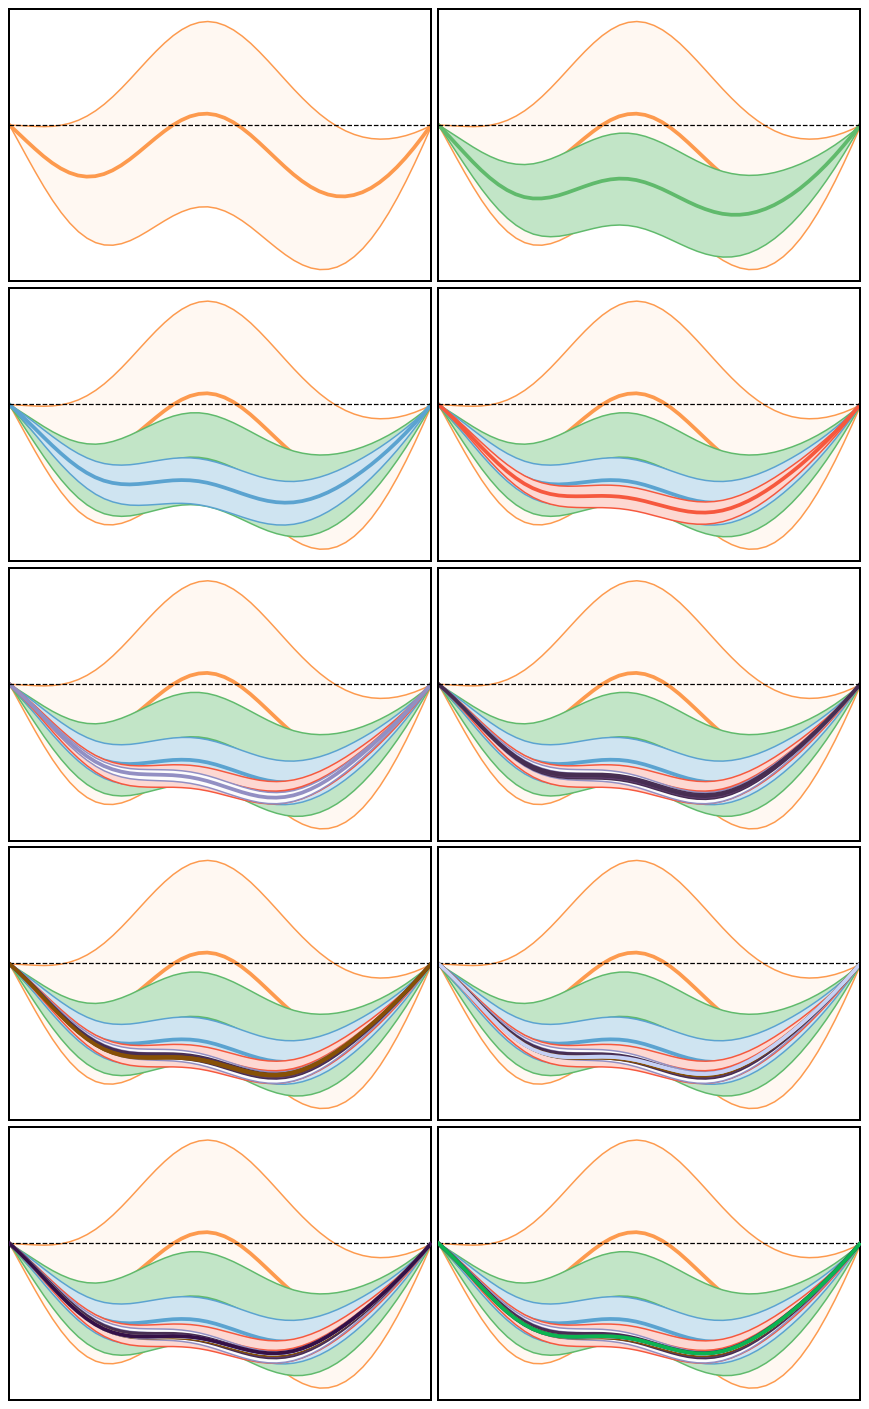

In [24]:
MyGPConstrained.PlotCurvesConstrained(constrained = True)

## Section III: Diagnostics

#### Figure 7(a): Coefficient curves fit to a subset of points with a Gaussian process

Here we split the data into a "training set" and a "testing set". The training set is indicated by the dots, and gives the data to which the GP used to assess the truncation error is fit. The location of the testing point is indicated by the tick marks on the x-axis. The solid line indicates the mean value of the GP for each EFT coefficient and the bubbles at the 95% DoB interval.

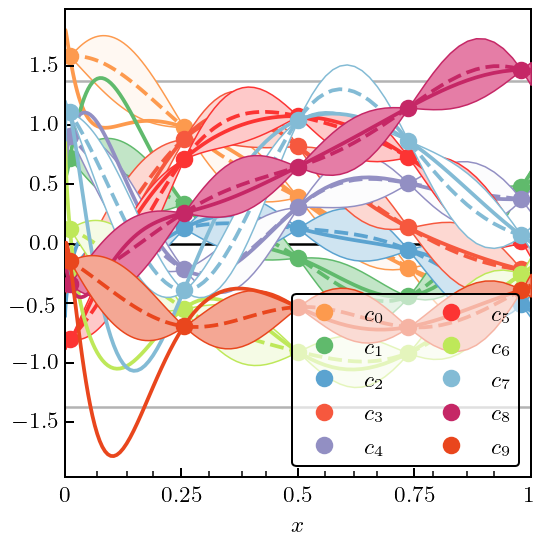

In [25]:
# creates the same GSUM object as before, but with different hyperparameters
JordanHyper = GPHyperparameters(ls = ls, sd = sd, center = 0, ref = ref, ratio = ratio, disp = 0, \
                                nugget = nugget, seed = seed, df = 1, scale = 1)
MyGP = GSUMobj(JordanHyper, OrdersBig, x, x_power = x_power)
MyGP.change_order(change_order_array, change_ratio_array, change_ls_array, change_sd_array, \
                   seed_array)
MyGP.PlotGPCurvesFit()

Here are the best guesses for $\bar c$ and $\ell$ after performing the fit

In [26]:
print(r'Std. dev. expected value:', MyGP.underlying_std)

Std. dev. expected value: 0.6872790788741463


In [27]:
np.sqrt(MyGP.gp_diagnostic.df_ * MyGP.gp_diagnostic.scale_**2 / (MyGP.gp_diagnostic.df_ + 2))

0.6608352930500179

In [28]:
# Print out the kernel of the fitted GP
MyGP.gp_diagnostic.kernel_

RBF(length_scale=0.206) + WhiteKernel(noise_level=1e-10)

#### Figure 7(b): Squared Mahalanobis distance

This is like a $\chi^2$ in the presence of correlations.
The correlations are assessed using the covariance matrix of the fitted GP.
Both the box-and-whisker and histogram versions are plotted.

Adjusted orders: [18 23 17 32 28]
Adjusted ratios: [0.3976083  0.55694049 0.60428248 0.43594273 0.54376489]
Adjusted correlation lengths: [0.18665662 0.1083576  0.20944282 0.1877757  0.14924598]
Adjusted variances: [1.0207087  0.70122115 0.88381051 0.98099935 0.72492258]
Adjusted seeds: [1440629  886656  136245 1944542  737047]


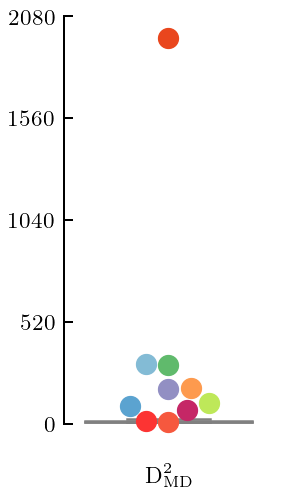

In [29]:
# we print the changed orders and their hyperparameters for ease of interpretation
MyGP.print_changed_orders()
MyGP.PlotMD(plot_type = 'box')

Adjusted orders: [18 23 17 32 28]
Adjusted ratios: [0.3976083  0.55694049 0.60428248 0.43594273 0.54376489]
Adjusted correlation lengths: [0.18665662 0.1083576  0.20944282 0.1877757  0.14924598]
Adjusted variances: [1.0207087  0.70122115 0.88381051 0.98099935 0.72492258]
Adjusted seeds: [1440629  886656  136245 1944542  737047]


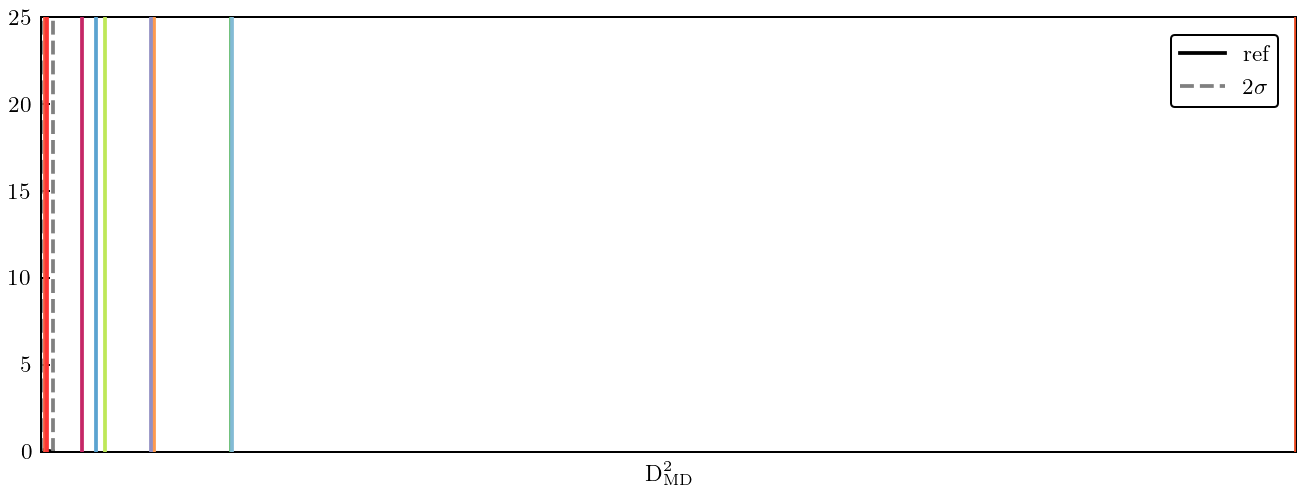

In [30]:
# we print the changed orders and their hyperparameters for ease of interpretation
MyGP.print_changed_orders()
MyGP.PlotMD(plot_type = 'hist')

#### Figure 7(c): Pivoted Cholesky errors
Now we decompose the Mahalanobis distance into its component pieces, by doing a Pivoted Cholesky decomposition on the covariance matrix. The resulting PC errors are then plotted against index. The index can be related to the testing point in question, see Bastos & O'Hagan's seminal article. Note that `gsum` has the ability to display Pivoted Cholesky (and several other) decompositions of the MD, see third line of code below. 

Adjusted orders: [18 23 17 32 28]
Adjusted ratios: [0.3976083  0.55694049 0.60428248 0.43594273 0.54376489]
Adjusted correlation lengths: [0.18665662 0.1083576  0.20944282 0.1877757  0.14924598]
Adjusted variances: [1.0207087  0.70122115 0.88381051 0.98099935 0.72492258]
Adjusted seeds: [1440629  886656  136245 1944542  737047]
The pivoted Cholesky decomposition could not be calculated at one or more orders.


C:\Users\pjmil\anaconda3\lib\_collections_abc.py:832: MatplotlibDeprecationWarning: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  self[key] = other[key]


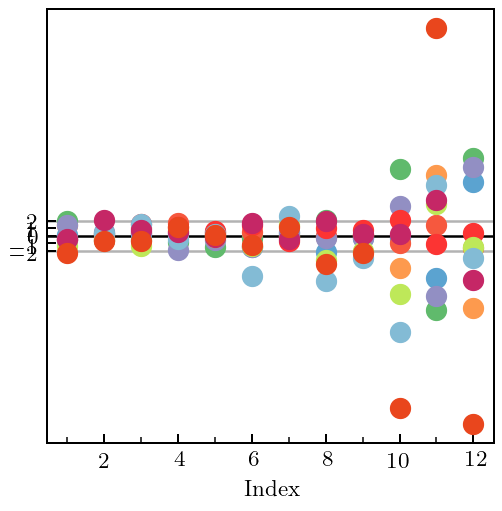

In [31]:
# we print the changed orders and their hyperparameters for ease of interpretation
MyGP.print_changed_orders()
MyGP.PlotPC()

### Figure 8

Now we compare the truncation errors computed at each order using the GP obtained above with the "true" (summed to order $n=20$) result from the toy EFT (dashed line), see Fig. 8(a). This comparison is done at the validation points indicated by the tick marks on the x-axis and produces the "Credible Interval Diagnostic" plot of Fig. 8(b). Note that `gsum` also has a command to generate this plot.

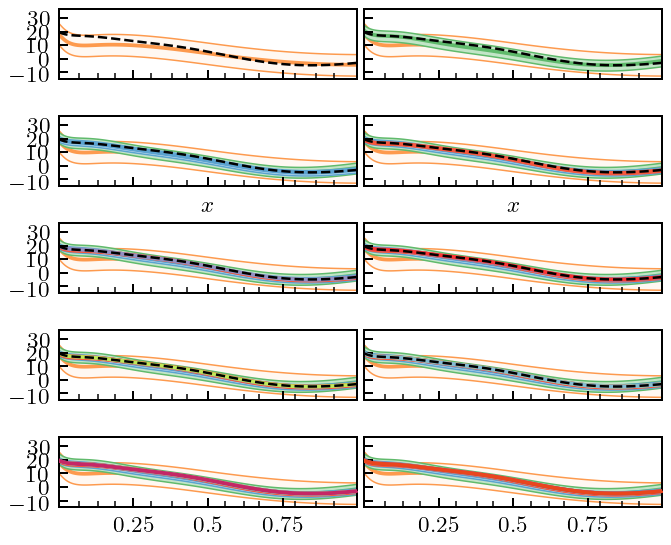

In [32]:
MyGP.PlotTruncations()

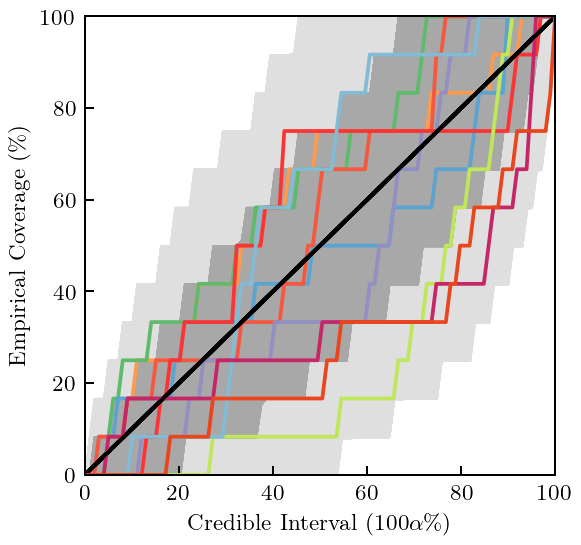

In [33]:
MyGP.PlotCredibleIntervals()

C:\Users\pjmil\anaconda3\lib\_collections_abc.py:832: MatplotlibDeprecationWarning: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  self[key] = other[key]


The posterior probability distribution could not be calculated.
Best Q: 0.5126582278481012
Best length scale: 0.20765656565656565


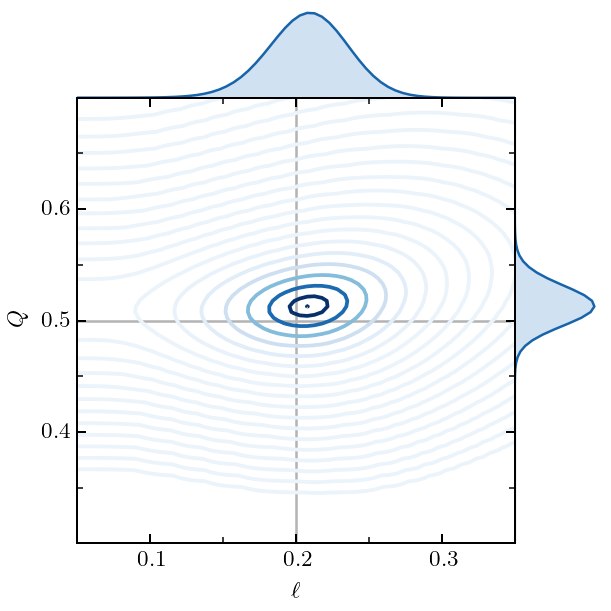

In [34]:
# posterior grid
JordanPosteriorBounds = PosteriorBounds(1e-3, 0.5, 100, 0.3, 0.7, 80)
MyGP.PlotPosteriorPDF(JordanPosteriorBounds)
ratio_map_idx, ls_map_idx = np.unravel_index(np.argmax(MyGP.ls_ratio_like), MyGP.ls_ratio_like.shape)
print('Best Q:', MyGP.ratio_vals[ratio_map_idx])
print('Best length scale:', MyGP.ls_vals[ls_map_idx])